# Chromosome karyotyping analysis

Chromosome karyotyping analysis is a screening and diagnostic procedure performed in clinical and cancer cytogenetic labs. Chromosome are first stained with a fluorescent dye, and then imaged through a microscope for subsequent analysis and classification. Each chromosome in the image has to be identified and assigned to one of 24 classes: the result is the so-called karyotype image in which all chromosomes in a cell are graphically arranged according to an international system for cytogenetic nomenclature (ISCN) classification. 

Source:
- https://www.fim.uni-passau.de/en/faculty/former-professors/mathematical-stochastics/chromosome-image-data/
- http://bioimlab.dei.unipd.it/Automatic%20Karyotyping%20Classification.htm
- http://bioimlab.dei.unipd.it/Chromosome%20Data%20Set%204Seg.htm
- https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html

This is mainly image processing demo of some of OpenCV library functions and my personal experiments.
Some promising cv2 functions are not usable at all for the purpose, so custom methods were prepared.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
img = cv2.imread('chromosomes_2.tiff')
img.shape

(582, 768, 3)

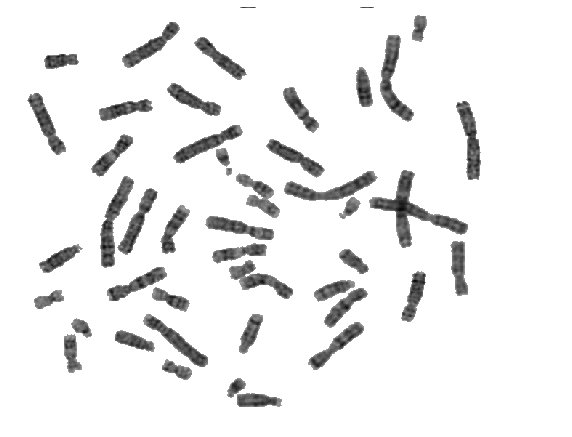

In [3]:
# Draw original figure
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# convert to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray.shape

(582, 768)

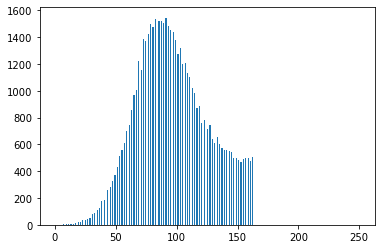

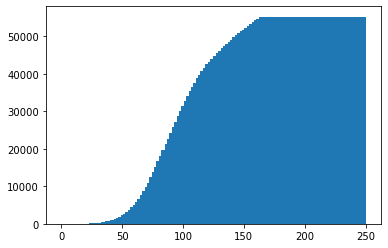

In [5]:
img_gray_flattened = img_gray.ravel()

# show histogram of intensities
# ignore white backgroud (use intensity <= 250)
plt.hist(img_gray_flattened,256,[0,250], cumulative=False)
plt.show()

# show histogram of intensities
plt.hist(img_gray_flattened,256,[0,250], cumulative=True)
plt.show()

# the image has already been somehow pre-processed

In [6]:
# binarize the image using threshold analysis
ret, img_bw = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img_bw.shape

(582, 768)

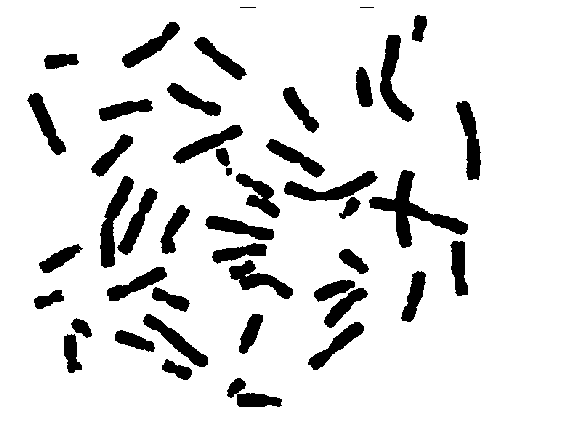

In [7]:
# draw binary/thresholded - show as negative image to see black chromosomes on white background
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(255 - img_bw, cv2.COLOR_BGR2RGB))
plt.show()

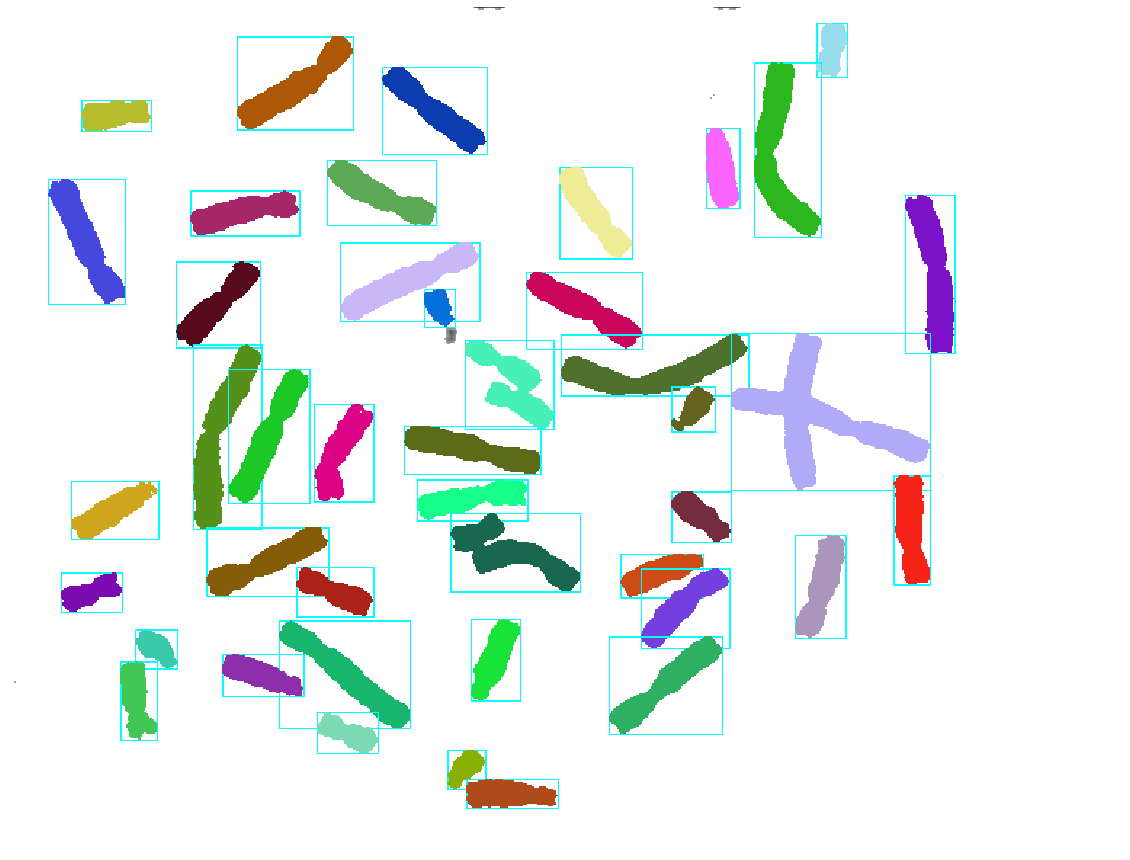

In [8]:
# analyze binary objects using connected components method
connectivity = 4
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_bw, connectivity, cv2.CV_32S)

# copy image
img2 = np.copy(img)

extracted_images = []

# ignore the 1st component
for i in range(1, nb_components):
    x = stats[i][cv2.CC_STAT_LEFT]
    y = stats[i][cv2.CC_STAT_TOP]
    w = stats[i][cv2.CC_STAT_WIDTH]
    h = stats[i][cv2.CC_STAT_HEIGHT]
    area = w*h
    
    if area<100:
        continue
    
    # create new image for an identified object
    img_extracted = np.full((h, w), 255, np.float) # white background
    extracted_images.append(img_extracted)
    
    # copy bytes by mask supplied in 'output' matrix
    for y2 in range(y, y + h):
        for x2 in range(x, x + w):           
            if (output[y2, x2] == i):
                img_extracted[y2 - y, x2 - x] = img_gray[y2, x2]
    
    # draw the bounding rectangele around each object
    cv2.rectangle(
        img2,
        (x, y),
        (x+w, y+h), 
        (255,255,0),
        1)
    
    # set mask color
    color = np.random.randint(255, size=3)
    img2[output == i] = color
        
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

Generating images...


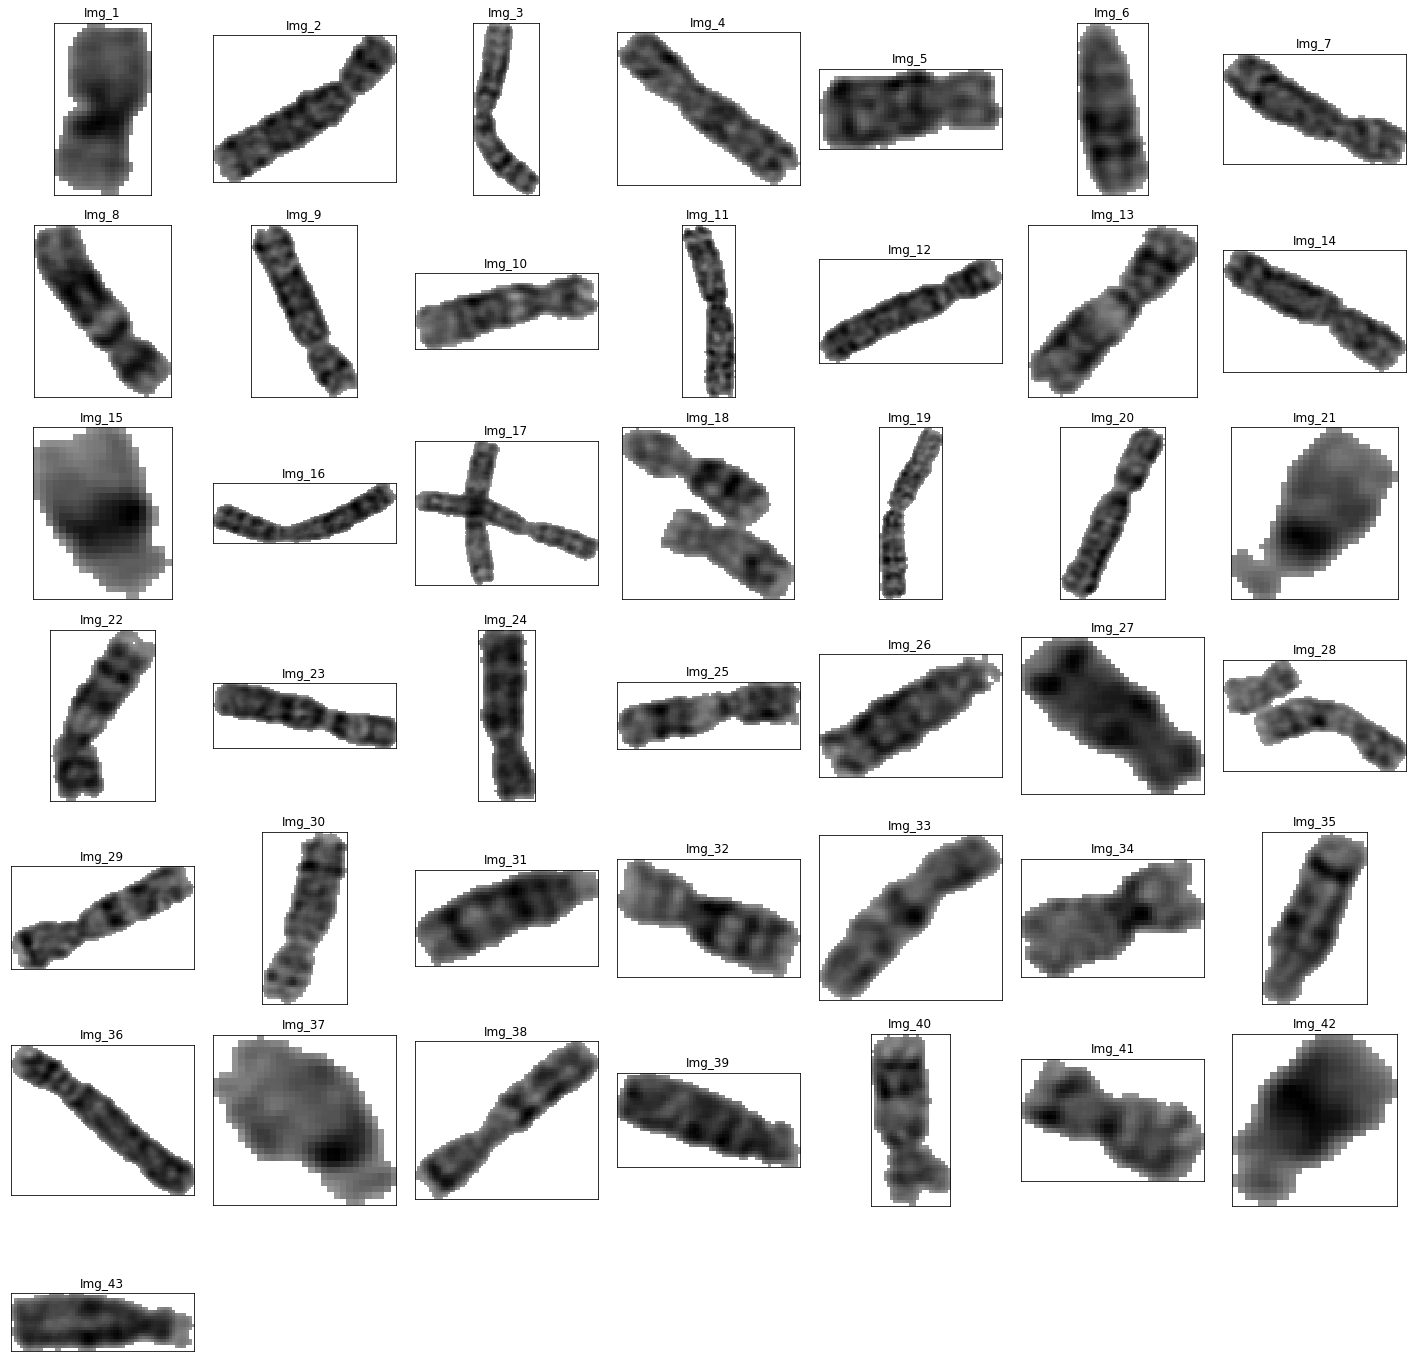

In [9]:
# Show all extracted images
print ('Generating images...')

n_extracted = len(extracted_images)
table_size = (int) (math.sqrt(n_extracted)) + 1

fig = plt.figure(figsize=(20,20))
for i in range(0, n_extracted):
    plt.subplot(table_size,table_size,i+1)
    plt.tight_layout()  
    plt.imshow(extracted_images[i], cmap='gray', interpolation='none')
    plt.title("Img_{}".format(i+1))
    plt.xticks([])
    plt.yticks([])

In [10]:
# the function computes an angle to rotate the object to be vertically oriented
# mechanical momentums are used (some physics is needed)
def get_object_deviation(img_gray, background_gray_color):
    w = img_gray.shape[1]
    h = img_gray.shape[0]    # target deviation
    
    alpha = 0
    
    # mechanical moments
    m00 = 0.0   # area
    m10 = 0.0   # linear. moments
    m01 = 0.0
    m20 = 0.0   # kvadrat. moments
    m02 = 0.0
    m11 = 0.0   # deviation moment
    cm20 = 0.0  # central moment
    pm20 = 0.0  # principal kvadratic moment
    cm02 = 0.0
    cm11 = 0.0  # central deviation moment

    #print ('w:', w, 'h:', h)
    
    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0
                y_1 = y + 1.0
                
                m00 += 1.0;
                m10 += x_1;
                m01 += y_1;
                m11 += x_1 * y_1;
                m02 += y_1 * y_1;
                m20 += x_1 * x_1;
                
    #print ('m00:', m00, 'm10:', m10, 'm01:', m01, 'm20:', m20, 'm02:', m02)

    if m00 == 0.0: # nothing to count
        #print ('m00==0')
        return alpha;     

    xc = m01 / m00;       # center of gravity
    yc = m10 / m00;
    
    #print ('xc:', xc, 'yc:', yc)

    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0 - xc
                y_1 = y + 1.0 - yc;
                cm02 += y_1 * y_1;
                cm20 += x_1 * x_1;
                cm11 += x_1 * y_1;

    # princial kvadratic moments are the same as moments moved to the center of gravity (Steiner's theorem)
    # in the center of gravity the linear moments are zero
    cm11 = m11 - xc*yc*m00;
    #print ('cm11:', cm11)

    # symetric object
    if cm20 == cm02:
        #print ('cm20 == cm02')
        return alpha

    # symetric object in one axis
    if cm11 == 0.0 and cm20 > cm02:
        #print ('cm11 == 0.0 and cm20 > cm02')
        alpha = 3.141593
        return alpha

    # symetric object in another axis
    if cm11 == 0.0:
        #print ('cm11 == 0.0')
        return alpha

    alpha = 0.5 * math.atan2(2.0 * cm11, (cm20 - cm02)) # = atan(y/x)

    # adjust angle
    alpha = 1.5707963 - alpha
    return alpha

In [11]:
# adapted from imutils.rotate_bound
def rotate_image(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    # white background
    dst = np.full((nH, nW), 255, np.float)

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), dst=dst, borderMode=cv2.BORDER_TRANSPARENT)

In [12]:
rotated_images = []

print ('Rotating images...')

for extracted_image in extracted_images:
    alpha = get_object_deviation(extracted_image, 255)
    alpha_degrees = 180.0*alpha/math.pi
    rotated = rotate_image(extracted_image, alpha_degrees)
    rotated_images.append(rotated)
    
print ('Done.')

Rotating images...
Done.


In [13]:
def crop_image(img_gray, background_gray_color):
    """
    Takes gray image and returns cropped image.
    """
    (h, w) = img_gray.shape[:2]
    x1 = w - 1
    y1 = h - 1
    x2 = 0
    y2 = 0
    
    for x in range(w):
        for y in range(h):
            color = img_gray[y,x]
            if color != background_gray_color:                               
                if x < x1:
                    x1 = x
                if x > x2:
                    x2 = x
                if y < y1:
                    y1 = y
                if y > y2:
                    y2 = y
    
    cropped = img_gray[y1 : y2+1, x1 : x2+1]
    return cropped

In [14]:
cropped_images = []

print ('Cropping images...')

for rotated_image in rotated_images:
    cropped = crop_image(rotated_image, 255)
    cropped_images.append(cropped)
    
print ('Done.')

Cropping images...
Done.


Generating images...
Done.


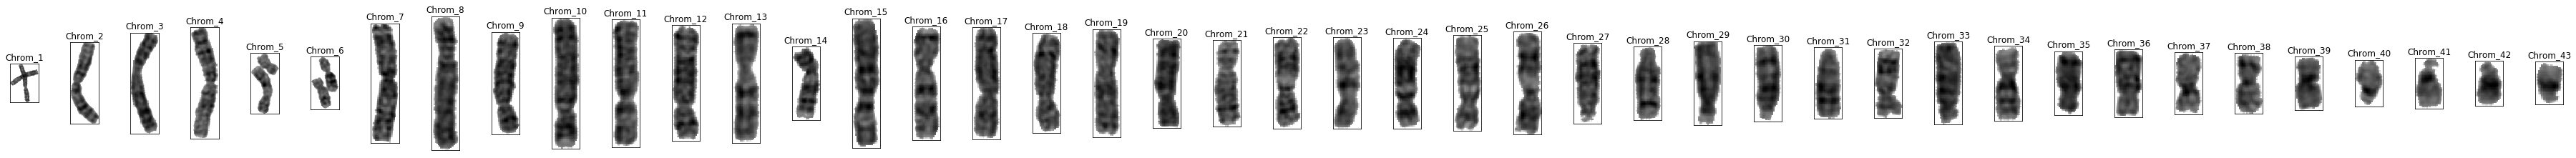

In [15]:
print ('Generating images...')

target_images = sorted(cropped_images, key=lambda image: image.shape[0]*image.shape[1], reverse=True)
n_extracted = len(target_images)

fig = plt.figure(figsize=(50,7))
for i in range(0, n_extracted):
    plt.subplot(1,n_extracted,i+1)
    plt.tight_layout()  
    plt.imshow(target_images[i], cmap='gray', interpolation='none')
    plt.title("Chrom_{}".format(i+1))
    plt.xticks([])
    plt.yticks([])
    
print ('Done.')

Overlapping or touching chromosomes require manual editation. Not covered here.

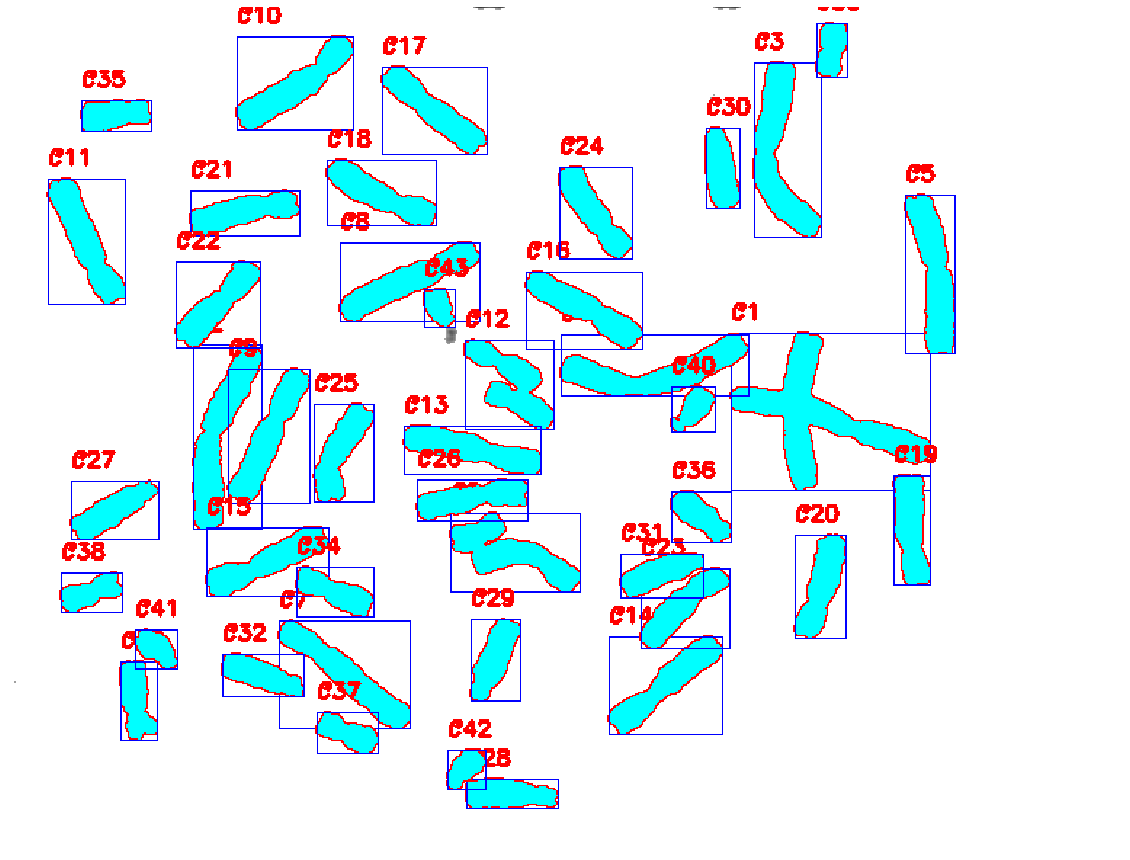

In [16]:
# detect objects by finding contours
img3 = np.copy(img)

contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sort contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending

# draw contours - fill with different border
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area<100:
        continue
    
    # border
    cv2.drawContours(img3, [contour], 0, (0,0,255), 2)    
    # fill
    cv2.drawContours(img3, [contour], 0, (255,255,0), -1)
    
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img3, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv2.putText(img3, "C{}".format(i + 1), (x, y-10), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.5, (0, 0, 255), 2)

# Draw original figure with rectangles
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
def prepare_image_for_seed_fill(img_bw):
    """
    Prepare binary image - 0 is background, 1 is object.
    """
    img_bw_dest = np.where(img_bw == 0, 1, 0).astype(int)
    return img_bw_dest


def find_objects_using_seed_fill(img_bw):
    """
    Detect objects from binary thresholded image using seed filling.
    """
    (h, w) = img_bw.shape[:2]
    # avoid recursion algorithm, which causes stack overflow for large objects,
    # use limited stack to explore pixel space
    stack_array = np.ndarray((30000,),int)
    # start with 2, 0 is background, 1 are thresholded objects, >=2 will be detected objects
    fill_color = 2
    
    for y in range(1, h-1):
        for x in range(1, w-1):
            color = img_bw[y, x]
            if color == 1: # this is new objects
                result = _seed_fill(img_bw, x, y, w, h, fill_color, stack_array)
                if result:
                    # prepare next color
                    fill_color += 1
                
    # number of detected objects
    return fill_color - 2


def _seed_fill(img_bw, x, y, w, h, fill_color, stack_array):
    """
    4-connected seed/flood fill algorithm avoiding recursion due to stack limit.
    """
    # index to the stack with x or y coordinates
    top_of_stack = -1;
    max_top_of_stack = len(stack_array) - 8
    color = 0
    
    while True:
        if x > 0 and x < w-1 and y > 0 and y < h-1:
            color = img_bw[y, x]
        else:
            color = 0 # black to ignore processing
            
        if color == 1: 
            # if not marked object pixel, then color the pixel with fill color
            # and continue with seed fill to 4 directions
            img_bw[y, x] = fill_color
            
            # search pixel neighbors
            if top_of_stack < max_top_of_stack:
                # push to stack - left
                top_of_stack += 1; stack_array[top_of_stack] = x+1
                top_of_stack += 1; stack_array[top_of_stack] = y
                # push to stack - right
                top_of_stack += 1; stack_array[top_of_stack] = x-1
                top_of_stack += 1; stack_array[top_of_stack] = y
                # push to stack - bottom
                top_of_stack += 1; stack_array[top_of_stack] = x
                top_of_stack += 1; stack_array[top_of_stack] = y+1          
                # push to stack - top
                top_of_stack += 1; stack_array[top_of_stack] = x
                top_of_stack += 1; stack_array[top_of_stack] = y-1
            else:
                print ('Too large object detected, finish.')
                return False

        if top_of_stack == -1:
            break
        else:
            # process stack
            y = stack_array[top_of_stack]; top_of_stack -= 1
            x = stack_array[top_of_stack]; top_of_stack -= 1

    return True


def find_objects_after_seed_fill(img_bw_seed):
    """
    Find rectangular boundaries of objects found by seed fill.
    """
    # key is color, value is map of x1,y1,x2,y2
    found_objects = {}
    
    (h, w) = img_bw_seed.shape[:2]
    
    for y in range(0, h):
        for x in range(0, w):
            color = img_bw_seed[y, x]
            if color == 0 or color == 1:
                continue
            
            obj = found_objects[color] if color in found_objects else None
            if obj is None:
                obj = {'x1' : x, 'x2' : x, 'y1' : y, 'y2' : y}
                found_objects[color] = obj
            else:
                x1 = obj['x1']
                x2 = obj['x2']
                y1 = obj['y1']
                y2 = obj['y2']
                
                if x < x1:
                    obj['x1'] = x
                if x > x2:
                    obj['x2'] = x
                if y < y1:
                    obj['y1'] = y
                if y > y2:
                    obj['y2'] = y
                    
    #print ('found_objects:', found_objects)
                    
    return found_objects                                      


def extract_objects_after_seed_fill(found_objects, img_bw_seed, img_gray):
    """
    Extract images of object found by seed fill.
    """
    detected_images = []
    
    for fill_color, coords in found_objects.items():
        x1 = coords['x1']
        x2 = coords['x2']
        y1 = coords['y1']
        y2 = coords['y2']
        w = x2 - x1
        h = y2 - y1
        
        area = w*h
        #print ('area:', area)
        
        # ignore small objects
        if area < 100:
            continue
            
        new_img = np.full((h,w), 255, np.float)
        detected_images.append(new_img)
        
        for x in range(x1, x2):
            for y in range(y1, y2):
                color = img_bw_seed[y,x]
                if color != fill_color:
                    continue
                new_img[y - y1,x - x1] = img_gray[y,x]
    
    return detected_images


def extract_objects(img_gray, img_bw):
    """
    Extract images of objects from gray image using thresholded image as binary mask.
    """
    img_bw_seed = prepare_image_for_seed_fill(img_bw)
    
    n_objects = find_objects_using_seed_fill(img_bw_seed)
    # print('Found:', n_objects)
    if n_objects == 0:
        raise('No object detected')

    found_objects = find_objects_after_seed_fill(img_bw_seed)
    extracted_images = extract_objects_after_seed_fill(found_objects, img_bw_seed, img_gray)
    return extracted_images

def get_vert_rotated_image(img_gray):
    """
    Find object deviation using mechanical momentums and rotate image. Enhance edges using erosion.
    """
    alpha = get_object_deviation(img_gray, 255)
    alpha_degrees = 180.0*alpha/math.pi
    rotated_img = rotate_image(img_gray, alpha_degrees)
    # erosion - trim border and garbage after rotating
    kernel = np.ones((2, 2), np.uint8)
    rotated_img = cv2.erode(rotated_img, kernel, cv2.BORDER_REFLECT)  
    cropped_img = crop_image(rotated_img, 255)
    return cropped_img

Generating images...
Done.


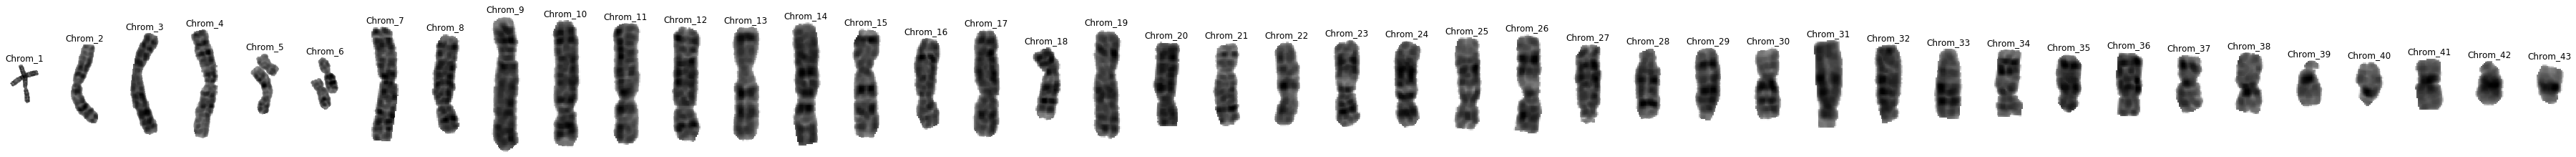

In [21]:
print ('Generating images...')

img_bw_inverted = 255 - img_bw

extracted_images = extract_objects(img_gray, img_bw_inverted)

extracted_images_rotated = []

for chrom_img in extracted_images:
    chrom_img_rotated = get_vert_rotated_image(chrom_img)
    extracted_images_rotated.append(chrom_img_rotated)

# sort desc by area
extracted_images_rotated = sorted(extracted_images_rotated, key=lambda image: image.shape[0]*image.shape[1], reverse=True)
    
fig = plt.figure(figsize=(50,7))
for i in range(0, n_extracted):
    plt.subplot(1,n_extracted,i+1)
    plt.tight_layout()
    plt.box()
    plt.imshow(extracted_images_rotated[i], cmap='gray', interpolation='none')
    plt.title("Chrom_{}".format(i+1))
    plt.xticks([])
    plt.yticks([])
    
print ('Done.')